# Analyse de la performance des modèles entrainés

Différents angles à analyser :
- Existe des classes présentes en nombre mais tout de même mal prédites ?
- A quoi resemble les libellés des classes mal prédites ? Ressemblent-ils à d'autres ? 
- Quelles sont les classes qui sont prédites avec les plus fortes/faibles proba ?
- Est-ce que les erreurs sont faites seulement lorsque la probab associée est faible ou non ?

In [1]:
import sys

import mlflow
import pandas as pd
import yaml

from constants import TEXT_FEATURE, Y
from fasttext_classifier.fasttext_evaluator import FastTextEvaluator
from fasttext_classifier.fasttext_preprocessor import FastTextPreprocessor
from fasttext_classifier.fasttext_trainer import FastTextTrainer
from fasttext_classifier.fasttext_wrapper import FastTextWrapper
from utils import get_root_path
from tqdm import tqdm

import dask.bag as db
import fasttext
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
preprocessor = FastTextPreprocessor()

In [3]:
df = pd.read_parquet("../data/extraction_sirene_20220602.parquet", engine="pyarrow")

config_path = "config/config_fasttext22.yaml"
with open(get_root_path() / config_path, "r") as stream:
    config = yaml.safe_load(stream)
params = config["params"]
categorical_features = config["categorical_features"]

In [4]:
df = df.sample(frac=0.025, random_state=1)

In [5]:
df_train, df_test, df_gu = preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)

In [6]:
df_naf = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naf.set_index("NIV5", inplace=True, drop=False)

In [7]:
df_prepro = pd.concat([df_train, df_test, df_gu])
df_prepro = preprocessor.get_aggregated_APE(df_prepro, Y)

In [8]:
b = db.from_sequence(df_prepro['LIB_SICORE'])

In [9]:
wordcount = (b.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(3000, lambda x: x[1]))  # sort and return top 10 words

list = wordcount.compute() # Run all tasks and return result


In [54]:
ListofWords = sorted(set([word for word,_ in list]))
df_word = pd.DataFrame({word :  df_prepro["APE_NIV1"][df_prepro["LIB_SICORE"].str.contains("\\b" + word + "\\b")].value_counts(normalize="true").kurtosis() for word in tqdm(ListofWords)}.items(), columns=['Words', 'Kurtosis'])
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )

100%|██████████| 3000/3000 [17:11<00:00,  2.91it/s]


In [64]:
df_word

,Words,Kurtosis
0,capillair,-5.950243
1,loto,-5.881840
2,ramonag,-5.872058
3,digitalis,-5.835394
4,videosurveil,-5.794530
...,...,...
2635,negoc,17.536718
2636,professionnel,17.734183
2637,export,17.742384
2638,transport,17.853963


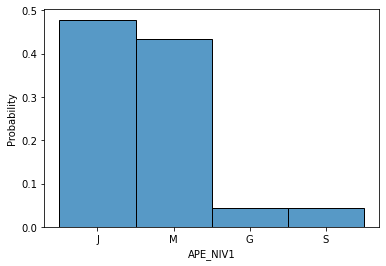

In [65]:
word = df_word.at[3, "Words"]
ax = sns.histplot(x="APE_NIV1", data=df_prepro[df_prepro["LIB_SICORE"].str.contains("\\b" + word + "\\b")], stat="probability")

In [58]:
df_naf[df_naf["NIV1"] == "J"].head(20)

,Unnamed: 0,NIV5,NIV4,NIV3,NIV2,NIV1,LIB_NIV5,LIB_NIV4,LIB_NIV3,LIB_NIV2,LIB_NIV1
NIV5,,,,,,,,,,,
58.11Z,525,58.11Z,58.11,58.1,58,J,Édition de livres,Édition de livres,Édition de livres et périodiques et autres act...,Édition,Information et communication
58.12Z,526,58.12Z,58.12,58.1,58,J,Édition de répertoires et de fichiers d'adresses,Édition de répertoires et de fichiers d'adresses,Édition de livres et périodiques et autres act...,Édition,Information et communication
58.13Z,527,58.13Z,58.13,58.1,58,J,Édition de journaux,Édition de journaux,Édition de livres et périodiques et autres act...,Édition,Information et communication
58.14Z,528,58.14Z,58.14,58.1,58,J,Édition de revues et périodiques,Édition de revues et périodiques,Édition de livres et périodiques et autres act...,Édition,Information et communication
58.19Z,529,58.19Z,58.19,58.1,58,J,Autres activités d'édition,Autres activités d'édition,Édition de livres et périodiques et autres act...,Édition,Information et communication
58.21Z,530,58.21Z,58.21,58.2,58,J,Édition de jeux électroniques,Édition de jeux électroniques,Édition de logiciels,Édition,Information et communication
58.29A,531,58.29A,58.29,58.2,58,J,Édition de logiciels système et de réseau,Édition d'autres logiciels,Édition de logiciels,Édition,Information et communication
58.29B,532,58.29B,58.29,58.2,58,J,Édition de logiciels outils de développement e...,Édition d'autres logiciels,Édition de logiciels,Édition,Information et communication
58.29C,533,58.29C,58.29,58.2,58,J,Édition de logiciels applicatifs,Édition d'autres logiciels,Édition de logiciels,Édition,Information et communication


In [66]:
xx = df_word["Words"][df_word["Kurtosis"]< df_word.Kurtosis.quantile(0.25)].to_list()

In [67]:
xx

['capillair',
 'loto',
 'ramonag',
 'digitalis',
 'videosurveil',
 'psycho',
 'lamp',
 'ruch',
 'affili',
 'herb',
 'vanner',
 'electrotechn',
 'feraill',
 'pap',
 'medit',
 'amenageur',
 'beignet',
 'prevoi',
 'detenu',
 'gym',
 'lapin',
 'biscuiter',
 'farin',
 'canard',
 'boulevard',
 'ballon',
 'revendr',
 'methanis',
 'medium',
 'lotisseur',
 'kiosqu',
 'lyon',
 'controle',
 'skipp',
 'motion',
 'cacao',
 'reprograph',
 'ecrit',
 'zero',
 'epic',
 'lucrat',
 'smartphon',
 'preponder',
 'sauvegard',
 'biograph',
 'print',
 'caban',
 'arbitrag',
 'hab',
 'logo',
 'selarl',
 'mandat',
 'paill',
 'vinif',
 'gestio',
 'alle',
 'vidang',
 'cano',
 'sticker',
 'ile',
 'adress',
 'resin',
 'immateriel',
 'remorquag',
 'barb',
 'lindustr',
 'aromatherap',
 'encaissement',
 'integral',
 'irrig',
 'signalet',
 'granul',
 'conten',
 'syndicat',
 'ain',
 'gravat',
 'shui',
 'feng',
 'depuis',
 'embel',
 'cardio',
 'reharmonis',
 'entraineur',
 'metallurg',
 'curag',
 'contract',
 'abris',
 'me

In [63]:
b = db.from_sequence(df["LIB_SICORE"])

distinct_words = (b.str.split()           # split into words
                  .flatten()             # chain all words lists
                  .distinct()
                  .count())


distinct_words.compute()

2204379

Pour importer un seul modèle spécifique, il suffit de run les commandes suivantes : 

- export PYTHONPATH="$PWD:$PYTHONPATH"

- export MC_HOST_minio=https://$AWS_ACCESS_KEY_ID:$AWS_SECRET_ACCESS_KEY:$AWS_SESSION_TOKEN@$AWS_S3_ENDPOINT

- mc cp -r minio/projet-ape/mlflow-artifacts/1/33e88b4c4a084622abfb102391e73af0/artifacts/default/artifacts/ models/

In [10]:
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)

In [13]:
res_gu = evaluator.get_aggregated_APE_dict(df_gu, Y, TEXT_FEATURE, categorical_features)
res_test = evaluator.get_aggregated_APE_dict(df_test, Y, TEXT_FEATURE, ["AUTO", "NAT_SICORE"])

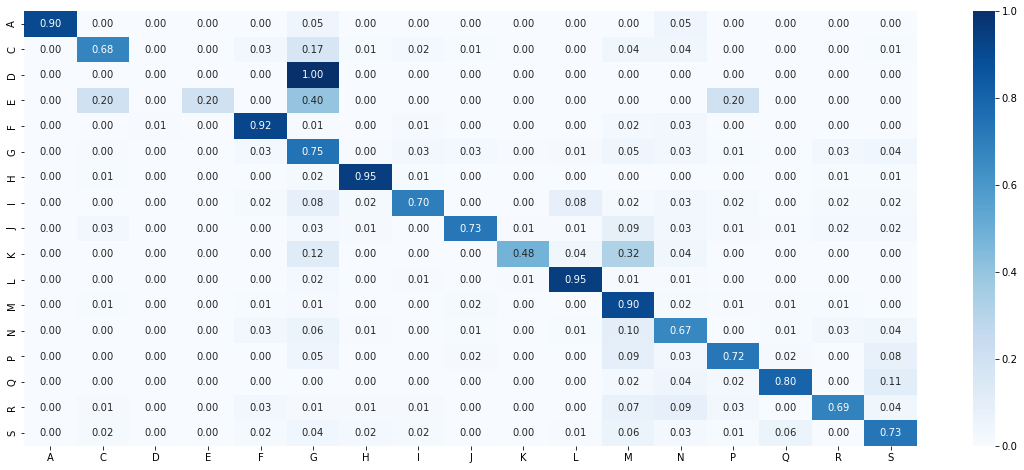

In [14]:
fig = evaluator.plot_matrix(res_gu[1])

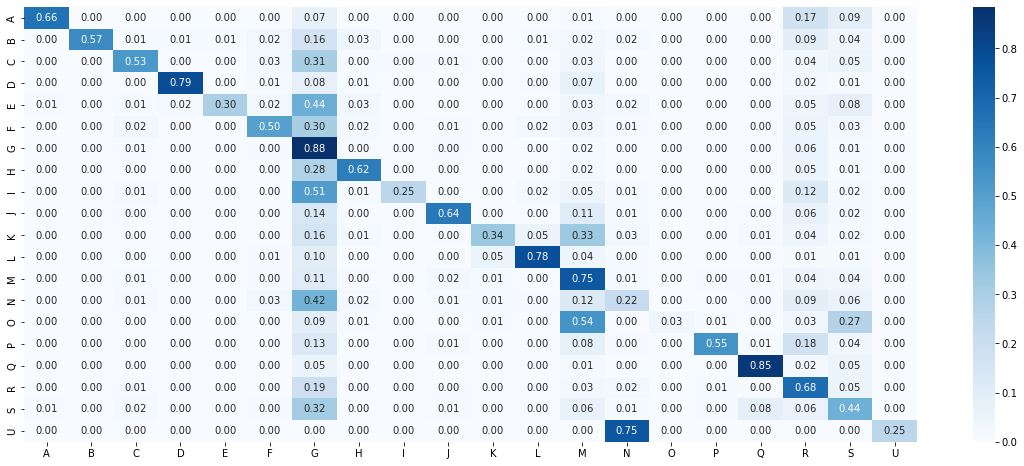

In [15]:
fig = evaluator.plot_matrix(res_test[1])

In [328]:
dff_prepro = pd.DataFrame(dff_prepro[1])
dff_prepro.set_index('liasseNb', inplace=True)
dff_prepro = dff_prepro.join(dff)   

In [334]:
b = db.from_sequence(dff_prepro['LIB_SICORE'])

wordcount = (b.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(100, lambda x: x[1]))  # sort and return top 10 words

list = wordcount.compute() # Run all tasks and return result


In [335]:
ListofWords = sorted(set([word for word,_ in list])) # + [word for word,_ in list_bad]

In [336]:
from tqdm import tqdm

In [337]:
df_word = pd.DataFrame({word :  dff_prepro["ground_truth"][dff_prepro["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis() for word in tqdm(ListofWords)}.items(), columns=['Words', 'Kurtosis'])

100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


In [387]:
df_word["Words"][df_word["Kurtosis"]< df_word.Kurtosis.quantile(0.25)].to_list()

['tout',
 'sans',
 'toute',
 'toutes',
 'autres',
 'organisation',
 'activite',
 'realisation',
 'service',
 'services',
 'sous',
 'formation',
 'activites',
 'creation',
 'operations',
 'prestations',
 'agent',
 'decoration',
 'production',
 'entretien',
 'domicile',
 'developpement',
 'electricite',
 'commercial',
 'reparation']

In [339]:
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )


In [375]:
df_word.Kurtosis.quantile(0.25)

7.4185355743914725

In [383]:
df_word.at[25, "Kurtosis"]

7.533529127555488

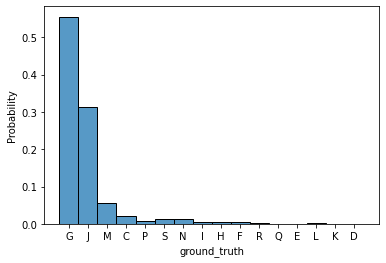

In [385]:
word = df_word.at[26, "Words"]
ax = sns.histplot(x="ground_truth", data=dff_prepro[dff_prepro["LIB_SICORE"].str.contains(word)], stat="probability")

In [318]:
df_word.head(15)

,Words,Kurtosis
0,batis,18.923900
1,renovation,21.600431
2,detail,25.980706
3,activite,28.823271
4,divers,29.280559
5,activites,29.359134
6,infirmiere,30.999380
7,alimentaires,32.188260
8,independant,32.538111
9,realisation,32.923861


## Analyse des classes mal prédites

In [81]:
df_res_gu = pd.DataFrame(res_gu[1])
df_res_gu.set_index('liasseNb', inplace=True)
df_res_gu = df_res_gu.join(df_gu)    

In [168]:
bad_pred = df_res_gu[(df_res_gu["ground_truth"] != df_res_gu["predictions"])] # (df_res_gu["probabilities"] > 0.7) &

In [169]:
b_all = db.from_sequence(df_res_gu['LIB_SICORE'])
b_bad = db.from_sequence(bad_pred['LIB_SICORE'])

wordcount_all = (b_all.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(100, lambda x: x[1]))  # sort and return top 10 words

wordcount_bad = (b_bad.str.split()   
             .flatten() 
             .frequencies()  
             .topk(100, lambda x: x[1])) 

list_all = wordcount_all.compute() # Run all tasks and return result
list_bad = wordcount_bad.compute() 

In [275]:
ListofWords = sorted(set([word for word,_ in list_all])) # + [word for word,_ in list_bad]

In [276]:
df_word = pd.DataFrame({word :  df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis() for word in ListofWords}.items(), columns=['Words', 'Kurtosis'])

In [277]:
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )


In [278]:
df_word.head(15)

,Words,Kurtosis
0,batiment,-1.824982
1,organisation,-0.795277
2,interieur,-0.699985
3,mise,-0.565660
4,etc,-0.494180
5,accessoires,0.285639
6,decoration,0.576386
7,internet,0.613151
8,divers,0.849551
9,tous,0.898726


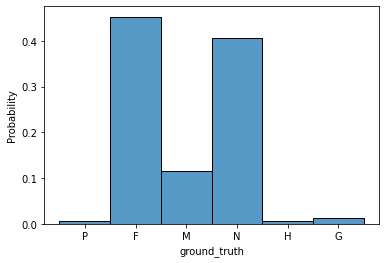

In [279]:
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(df_word.at[0, 'Words'])], stat="probability")

Mots les plus fréquents dans le fichiers du guichet unique qui sont également présents dans les plus mal prédits

In [85]:
[word for word,_  in list_all if word in [word_b for word_b,_  in list_bad]]

['conseil',
 'entreprises',
 'vente',
 'creation',
 'domicile',
 'services',
 'produits',
 'travaux',
 'fabrication',
 'service',
 'livraison',
 'entretien',
 'prestations',
 'nettoyage',
 'formation']

Mots les plus fréquents dans les plus mal prédits qui ne sont pas présents dans les plus fréquents dans le fichier du guichet unique

In [86]:
[tup for tup  in list_bad if tup[0] not in [word for word,_  in list_all]]

[('realisation', 11),
 ('montage', 11),
 ('meubles', 10),
 ('decoration', 10),
 ('bricolage', 9),
 ('accompagnement', 9),
 ('design', 8),
 ('petits', 7),
 ('reparation', 7),
 ('divers', 7)]

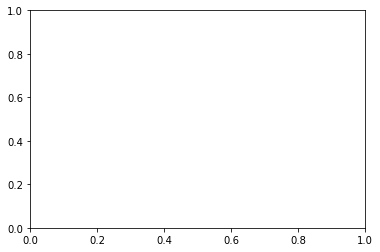

In [319]:
#word = "conseil"
word = "ongulaire"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

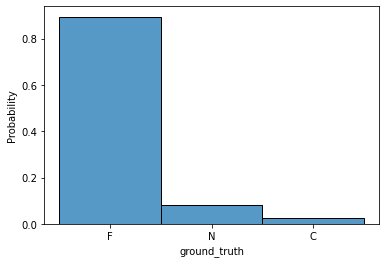

In [196]:
word = "maconnerie"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [201]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurt()

nan

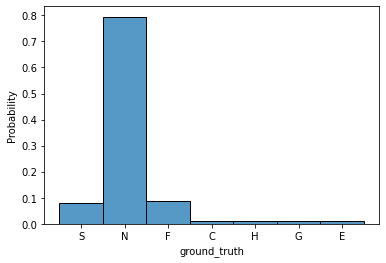

In [160]:
word = "bricolage"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [161]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis()

6.673929939510314

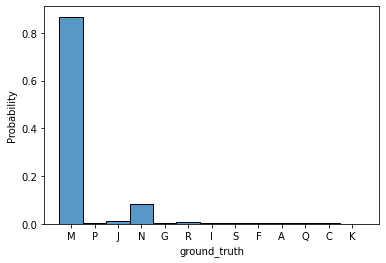

In [155]:
word = "entreprises"
ax = sns.histplot(x="ground_truth", data=df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)], stat="probability")

In [156]:
df_res_gu["ground_truth"][df_res_gu["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis()

12.720332308031425

In [110]:
df_res_gu[df_res_gu["LIB_SICORE"].str.contains(word)]

,ground_truth,predictions,probabilities,APE_NIV5,LIB_SICORE,AUTO,NAT_SICORE
liasseNb,,,,,,,
J00010000461,J,R,0.129413,5912Z,realisation dessins animation,X,NaN
J00010005106,J,J,0.136618,6201Z,realisation site web charte graphique seo prin...,X,NaN
J00010016848,S,S,0.999457,9609Z,realisation tatouages artistiques,X,NaN
J00010007086,J,J,0.160276,5913B,realisation audiovisuelle tournage montage eta...,X,NaN
J00010010288,J,J,0.817585,5911B,realisation clips video captation edition dest...,C,04
...,...,...,...,...,...,...,...
J00010187755,F,F,0.782673,4399C,realisation travaux maconnerie tout genre,M,99
J00010186708,J,M,0.787941,5911B,realisation video secteurs prives publics cadr...,L,NaN
J00010188324,C,C,0.437833,1413Z,realisation vetements objets crochet,M,04


In [ ]:
df_train, df_test, df_gu = preprocessor.preprocess(
    df=df,
    y=Y,
    text_feature=TEXT_FEATURE,
    categorical_features=categorical_features,
)
df = pd.concat([df_train, df_test, df_gu])
model = fasttext.load_model("../models/default.bin")
evaluator = FastTextEvaluator(model)
df_prepro = evaluator.get_aggregated_APE_dict(df, Y, TEXT_FEATURE, categorical_features)
df_naff = pd.read_csv(r"../data/naf_extended.csv", dtype=str)
df_naff.set_index("NIV5", inplace=True, drop=False)
b = db.from_sequence(df_prepro['LIB_SICORE'])

wordcount = (b.str.split()       # split into words
             .flatten()                  # chain all words lists
             .frequencies()              # compute occurences
             .topk(3000, lambda x: x[1]))  # sort and return top 10 words

list = wordcount.compute() # Run all tasks and return result

ListofWords = sorted(set([word for word,_ in list])) # + [word for word,_ in list_bad]
df_word = pd.DataFrame({word :  df_prepro["ground_truth_1"][df_prepro["LIB_SICORE"].str.contains(word)].value_counts(normalize="true").kurtosis() for word in tqdm(ListofWords)}.items(), columns=['Words', 'Kurtosis'])
df_word = (df_word
            .dropna()
            .sort_values(by=['Kurtosis'])
            .reset_index(drop=True)
            )

xx = df_word["Words"][df_word["Kurtosis"]< df_word.Kurtosis.quantile(0.25)].to_list()